# Physics-informed DeepONet: Solving a ODE for different right hand sides
In this notebook, we present an introduction to the physics-informed DeepONet [(paper)](https://arxiv.org/abs/2103.10974) utilities of TorchPhysics.
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}
for different functions $f$. Before describing the implementation in TorchPhysics we give a short recall of DeepONets.


# Recall of Deep Operator Networks (DeepONets)

We wish to learn the solution $u_f:[0,1]\to \mathbb{R}$ for many different choices of functions $f:[0,1]\to \mathbb{R}$ by a DeepONet $\varphi_{\theta}.$
The construction of DeepOnets is described in what follows:

1) The basic idea is to represent $u_f$ as a linear combination of neural networks $\varphi_i:[0,1]\to \mathbb{R}$
$$
u_f(t) \approx \sum_{i=1}^n c_i(f) \varphi_i(t),
$$
where the coefficients $c_i(f)$ depend on the parameter function $f$ that leads to the solution $u_f$ of the ODE above.

2) We would wish to replace $c_i(f)$ by a neural network, too. However, we cannot use a function $f$ as an input of a neural network. Instead, we collect finitely many information about $f$ by sampling $f$ at sampling points $t_1, ..., t_k$. These serve as inputs of neural networks $\psi_i$ for approximating the coefficients
$$
c_i(f) \approx \psi_i( f(t_1), ..., f(t_k) ).
$$

3) A DeepONet $\varphi_\theta$ is hence defined as
$$
\varphi_\theta(f,t) := \sum_{i=1}^n \psi_i( f(t_1),...,f(t_k) ) \varphi_i(t) ≈u_f(t).
$$
Typically, all $\psi_i$ are collected within a single neural network, the so-called branch net $\varphi_{branch}:[0,1] \to \mathbb{R}^n$, whose output coordinates just represent the $\psi_i$. Similarly, the $\varphi_i$ are represented by a so-called trunk net $\varphi_{trunk}:[0,1] \to \mathbb{R}^n$.
So the branch net receives only information about the parameter function $f$, whereas the input of the trunk net is the coordinate $t$ at which the solution $u_f$ is to be approximated.
Note that the sampling points $t_1, ..., t_k$ needs to be fixed beforehang and should not be changed for different $f$, simply to not confuse the branch net $\varphi_{branch}$.

# Physics-informed DeepONets in TorchPhysics

The general structure of TorchPhysics still holds for DeepONet problems, so we can follow the same step-by-step recipe as in the [PINN-tutorials](https://torchphysics.de/tutorial).
However, we need some new concepts to define training functions of $f$. Here we show, how to:

- create a function space for different training functions
- define a DeepONet-neural-network consisting of a trunk and branch net

and some additional details one has to consider.

In [76]:
import os
import torch
import torchphysics as tp
import pytorch_lightning as pl

## Step 1: Specify spaces and domains
As in the PINN tutorials we need to specify the input and output spaces of the solution functions $u_f:[0,1]\to \mathbb{R}$.

In [77]:
# Input and output spaces
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable

# Domain of u_f
T_interval = tp.domains.Interval(T, 0, 1)

The DeepONet tries to learn $u_f$ for many different parameter functions $f$. Therefore, we need to define a set of functions $f$ that will be used for training the DeepONet.
We consider the function set that consist of the following parameterized functions for $k\in [0,6]$
$$
f_1(t, k) = kt,\\
f_2(t, k) = kt^2,\\
f_3(t, k) = k\cos(kt).
$$

In [78]:
def f1(k, t):
    return k*t
def f2(k, t):
    return k*t**2
def f3(k, t):
    return k*torch.cos(k*t)

In order to construct this function set in TorchPhysics, we need to create input and output spaces for these functions $f_i$, similar to what we did with $u_f$. Here, also the parameter $k$ is treated as an input. Note that for the input variable $t$ we do not specify a space and domain again, as we already did that above.

In [79]:
# Input and output spaces for the parameterized functions f_1, f_2, f_3
K = tp.spaces.R1('k') # Parameter
F = tp.spaces.R1('f') # Function output space name
# Domains
K_interval = tp.domains.Interval(K, 0, 6) # Parameters will be scalar values

If different ranges for $k$ were to be used for different $f_i$, one would have needed to create multiple parameter spaces and domains.

The function set of all $f_i$ for all $k\in [0,6]$ is considered as a domain object in TorchPhysics, simply because this set serves as the input for the branch net of the DeepONet. The constructor of CustomFunctionSet(...) receives three inputs:
- A function space that specifies the input and output spaces of the functions $f_i:[0,1]\subset \mathbb{R} \to \mathbb{R}$;
- A sampler for providing different parameters $k$;
- The parameterized function $f_i$ that represents the function set.

We first create function sets for all $f_i$ individually and afterwards obtain the union by the "append()" method of the FunctionSet class.

In [80]:
# Defining function set
Fn_space = tp.spaces.FunctionSpace(T, F)

param_sampler = tp.samplers.RandomUniformSampler(K_interval, n_points=5000)

Fn_set_1 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f1)
Fn_set_2 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f2)
Fn_set_3 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f3)

Fn_set = Fn_set_1.append(Fn_set_2).append(Fn_set_3) # A.append(B) computes the union of the function sets A and B.

Mathematically, Fn_set represents the function set
$$
\{ f_i(\cdot , k): \text{for } i=1,2,3 \text{ and } k\in [0,6] \}.
$$

## Step 2: Define point samplers
As in the PINN tutorials we need to define samplers for the ODE condtion and the initial condition.

In [81]:
sampler_ode_condition = tp.samplers.RandomUniformSampler(T_interval, 1000)

sampler_initial_condition = tp.samplers.RandomUniformSampler(T_interval.boundary_left, 500)

During the training, functions from the functions set "Fn_set" need to be selected/sampled. This is done by a "FunctionSamplerRandomUniform", which randomly selects functions from the function set.

In [82]:
# Each time the function sampler is called, we want to randomly select n_functions=5000 functions from the function set Fn_set.
# Once created, it may be beneficial to reuse these functions for the next 100 calls of the function sampler before generating new ones
# This can simply be achieved by setting specify function_creation_interval=100.
function_sampler = tp.samplers.FunctionSamplerRandomUniform(
    n_functions=5000, 
    function_set=Fn_set, 
    function_creation_interval=100
    )

## Step 3: Define residual functions
Similar to $u$, the parameter function $f$ occuring in the ODE condition will already have been sampled when the residual functions are called. Therefore, we define the residual functions as:

In [83]:
def residual_ode_condition(u, t, f):
    return tp.utils.grad(u, t) - f

def residual_initial_condition(u):
    return u


## Step 4: Define DeepONet

The branch net in TorchPhysics needs to know the function space the parameter functions $f$ belong to. Further, it needs to know the points $t_1,.,,,t_k$ at which these $f$ are to be sampled. As mentioned in the recall, these sampling points should be fixed and never changed. These sampling points, called "time_grid" below, can just be obtained by for example a GridSampler and using the"sample_points()" method.

In [84]:
# Branch net
time_grid = tp.samplers.GridSampler(T_interval, 30).sample_points()
# We choose a fully connected network for the branch net, in TorchPhysics: FCBranchNet(...)
branch_net = tp.models.FCBranchNet(Fn_space, hidden=(20, 20), grid=time_grid)

Also for the trunk net we choose a fully connected network.

In [85]:
trunk_net = tp.models.FCTrunkNet(T, hidden=(10, 10), default_trunk_input=time_grid)

The constructor of the DeepONet receives just the trunk net, the branch net, the output space of the solution functions $u_f$, as well as the output dimension $n$ of the branch and trunk nets. We set the output dimension to $30$. Having a look at the DeepONet recall again, this means that the DeepONet can represent a function vector space of dimension $\leq 30$.

In [86]:
deeponet = tp.models.DeepONet(trunk_net, branch_net, output_space=U, output_neurons=30)

## Step 5: Create TorchPhysics Conditions
Almost done: We only need to define the TorchPhysics conditions for the ODE and initial condition. Since the DeepONet is to be trained physics-informed, we need to define PIDeepONetConditions.
The main inputs for the constructor of such a condition are:
- deeponet_model: the model that should be trained on this condition;
- branch_function_sampler: the function sampler that generates functions $f_i$ as inputs of the branch net;
- trunk_points_sampler: samples points at which the ode condition should be satisfied. These are fed into the trunk networks;
- residual_fn: residual function for the respective pde/ode condition.

In [87]:
# Conditions for the ODE problem
ode_condition = tp.conditions.PIDeepONetCondition(deeponet_model=deeponet,
                                                  branch_function_sampler=function_sampler,
                                                  trunk_points_sampler=sampler_ode_condition,
                                                  residual_fn=residual_ode_condition)
# Note: If logging via Tensorboard is desired, just add name='ode_condition' as an input of the PIDeepONetCondition. Works also for all other conditions, such as PINNCondition. 

initial_condition = tp.conditions.PIDeepONetCondition(deeponet_model=deeponet,
                                                      branch_function_sampler=function_sampler,
                                                      trunk_points_sampler=sampler_initial_condition,
                                                      residual_fn=residual_initial_condition)

# Training

In [88]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([ode_condition, initial_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/s_e8mv8u/anaconda3/envs/torchphysics/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/s_e8mv8u/PhD/torchphysics/examples/tutorial/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 2.1 K  | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
/home/s_e8mv8u/anaconda3/envs/torchphysics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 

Training: |          | 0/? [00:00<?, ?it/s]

/home/s_e8mv8u/PhD/torchphysics/src/torchphysics/problem/domains/functionsets/functionset_operations.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.current_idx = torch.tensor(idx, dtype=torch.long, device=self.device)


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.


# Comparison with ground truth

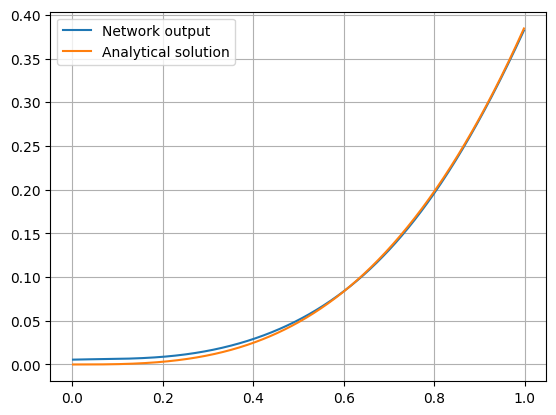

In [89]:
import matplotlib.pyplot as plt

k0 = 1.16
def f(t):
    return k0 * t**2

def F(t): # ground truth solution u_f
    return k0/3.0 * t**3

deeponet.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(T_interval, 500)
grid_points = grid_sampler.sample_points().as_tensor
out = deeponet(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]

grid_p = grid_points
plt.plot(grid_p, out)
plt.plot(grid_p, F(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])
plt.show()

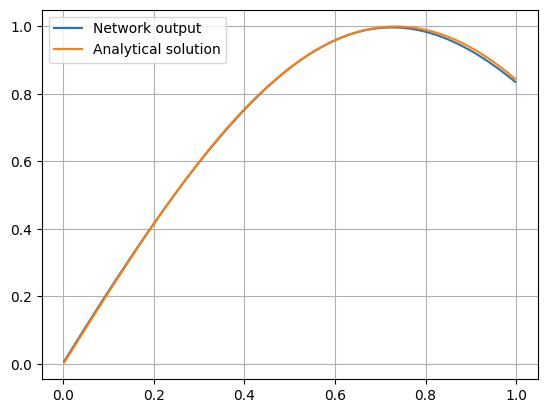

In [90]:
k0 = 2.14
def f(t):
    return k0 * torch.cos(k0*t)

def F(t): # ground truth solution u_f
    return torch.sin(k0*t)

deeponet.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(T_interval, 500)
grid_points = grid_sampler.sample_points().as_tensor
out = deeponet(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]

grid_p = grid_points
plt.plot(grid_p, out)
plt.plot(grid_p, F(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])
plt.show()